## Credit Card Client Defaulter Classification

In [375]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
import seaborn as sn

# Pre-processing packages
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

#import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc, roc_curve, roc_auc_score 

# CV, Gridsearch, train_test_split, model selection packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate 
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn import linear_model, datasets
from imblearn.over_sampling import SMOTE

In [374]:
data = pd.read_csv('default of credit card clients.csv',  header =1)

In [350]:
data.isnull().values.any()
#print(data.dtypes)
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,female,university,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,default
1,2,120000,female,university,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,default
2,3,90000,female,university,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,not default
3,4,50000,female,university,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,not default
4,5,50000,male,university,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,not default


In [351]:
#pandas_profiling.ProfileReport(data)
print('Education:', data['EDUCATION'].unique())
print('SEX:', data['SEX'].unique())
print('MARRIAGE:', data['MARRIAGE'].unique())
print('PAY_0:', data['PAY_0'].unique())
print('PAY_2:', data['PAY_0'].unique())
print('PAY_3:', data['PAY_0'].unique())
print('PAY_4:', data['PAY_0'].unique())
print('PAY_5:', data['PAY_0'].unique())
print('PAY_6:', data['PAY_0'].unique())
print('default payment next month:', data['default payment next month'].unique())


Education: ['university' 'graduate school' 'high school' 'other']
SEX: ['female' 'male']
MARRIAGE: [1 2 3 0]
PAY_0: [ 2 -1  0 -2  1  3  4  8  7  5  6]
PAY_2: [ 2 -1  0 -2  1  3  4  8  7  5  6]
PAY_3: [ 2 -1  0 -2  1  3  4  8  7  5  6]
PAY_4: [ 2 -1  0 -2  1  3  4  8  7  5  6]
PAY_5: [ 2 -1  0 -2  1  3  4  8  7  5  6]
PAY_6: [ 2 -1  0 -2  1  3  4  8  7  5  6]
default payment next month: ['default' 'not default']


In [352]:
#pre-process the data
# rename the column to DEFAULT
data = data.rename(columns={"default payment next month": "DEFAULT"})
# Encode labels in column 'DEFAULT'. 
data.loc[(data.DEFAULT == 'not default'), 'DEFAULT'] = 0
data.loc[(data.DEFAULT == 'default'), 'DEFAULT'] = 1

# drop ID column as it does not add any value in analysis
data.drop(['ID'],axis=1, inplace=True)

#remove all records where marriage status is unknown, this is very small percentage anyways.
#remove all records where Eduction level is other, this is very small percentage anyways.
data = data[(data['MARRIAGE'] != 0) & (data['EDUCATION'] != 'other')]

labelencoder = LabelEncoder()
# Assigning numerical values to non numeric categorial variables
data['EDUCATION'] = labelencoder.fit_transform(data['EDUCATION'])
data['SEX'] = labelencoder.fit_transform(data['SEX'])

data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000,0,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,0,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,0,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,0,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


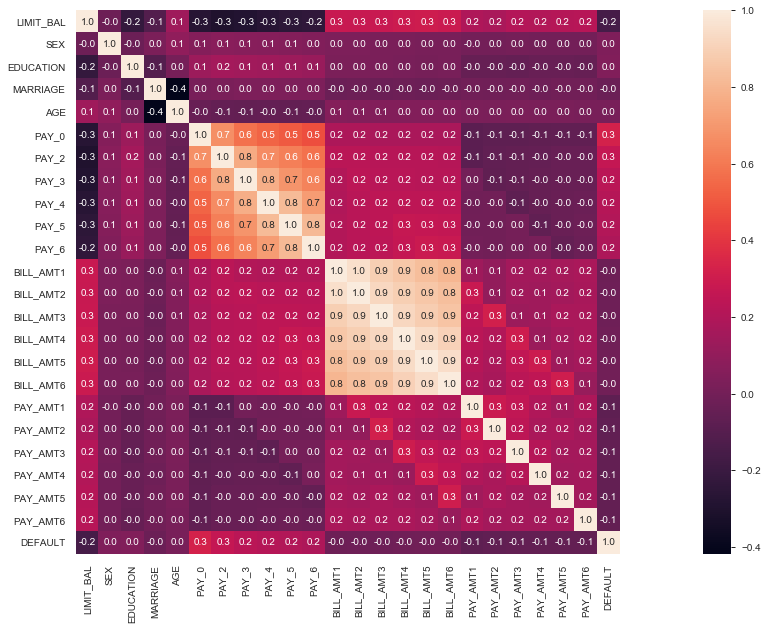

In [353]:
#Correlation matrix to see relation in age and online shopping
corr_mat = data.corr()
#print(corr_mat)
plt.subplots(figsize=(30,10))
sn.heatmap( corr_mat, square=True, annot=True, fmt=".1f" )  

In [354]:
data.groupby(['DEFAULT'])['DEFAULT'].count()

DEFAULT
0    22880
1     6598
Name: DEFAULT, dtype: int64

6598


Text(-0.35, 10000, 'No Default: 22880')

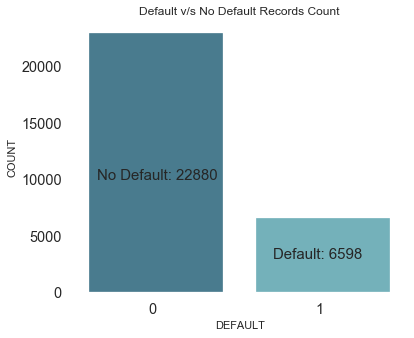

In [355]:
plt.figure(figsize=(6,5))
sn.countplot(x='DEFAULT', data=data, palette='GnBu_d').set_title('Default v/s No Default Records Count')
plt.xticks(horizontalalignment='right', fontsize='x-large'  )
plt.yticks(horizontalalignment='right', fontsize='x-large'  )
plt.ylabel('COUNT')
print(default)
plt.annotate('Default: {}'.format(len(data[data['DEFAULT'] == 1])), 
             xy=(0.7, 3000), # xy = (x dist from 0, y dist from 0)
            size=15)
plt.annotate('No Default: {}'.format(len(data[data['DEFAULT'] == 0])), 
             xy=(-.35, 10000), # xy = (x dist from 0, y dist from 0)
            size=15)

In [356]:
#Calculate default percentages by SEX
data1 = data.groupby(['SEX','DEFAULT'])['DEFAULT'].count()
data1.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

SEX  DEFAULT
0    0          78.952402
     1          21.047598
1    0          75.589542
     1          24.410458
Name: DEFAULT, dtype: float64

In [357]:
#Calculate default percentages by Education
data1 = data.groupby(['EDUCATION','DEFAULT'])['DEFAULT'].count()
data1.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

EDUCATION  DEFAULT
0          0          80.757962
           1          19.242038
1          0          74.697312
           1          25.302688
2          0          76.262122
           1          23.737878
Name: DEFAULT, dtype: float64

In [358]:
#Calculate default percentages by Marriage
data1 = data.groupby(['MARRIAGE','DEFAULT'])['DEFAULT'].count()
print(data1)

data1 = data1.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).unstack()
#print(data1)
#data1.plot(kind='bar', stacked=True)


MARRIAGE  DEFAULT
1         0          10236
          1           3189
2         0          12413
          1           3325
3         0            231
          1             84
Name: DEFAULT, dtype: int64


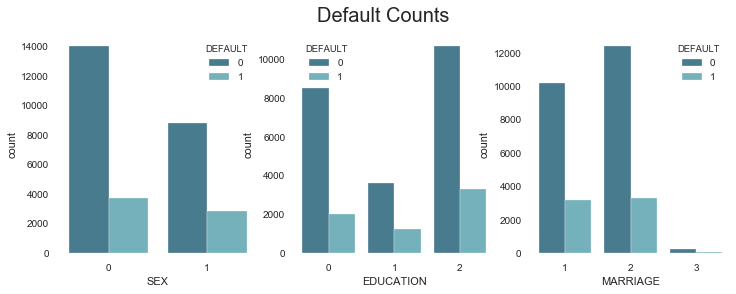

In [359]:
p, axes = plt.subplots(1, 3, figsize=(12,4), facecolor='white')
p.suptitle("Default Counts",size=20)
x1 = sn.countplot(x='SEX', hue = 'DEFAULT', data=data, palette='GnBu_d', ax=axes[0])
x2 = sn.countplot(x='EDUCATION', hue = 'DEFAULT', data=data, palette='GnBu_d', ax=axes[1])
x3 = sn.countplot(x='MARRIAGE', hue = 'DEFAULT', data=data, palette='GnBu_d', ax=axes[2])

In [360]:
data[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].describe()
df = data.groupby(['PAY_0'])['PAY_0'].count().to_frame(name = 'PAY0').reset_index()
df.columns = ['Indicator', 'PAY0']
for i in range(2,7):
    df['Pay'+str(i)] = data.groupby(['PAY_'+str(i)])['PAY_'+str(i)].count().to_frame(name = 'PAY'+str(i)).reset_index()['PAY'+str(i)]

print(df)

    Indicator   PAY0   Pay2   Pay3   Pay4     Pay5     Pay6
0          -2   2679   3691   3996   4253   4444.0   4771.0
1          -1   5610   5955   5829   5583   5452.0   5647.0
2           0  14444  15420  15461  16150  16625.0  15995.0
3           1   3649     28      4      2   2616.0   2753.0
4           2   2637   3903   3801   3141    177.0    183.0
5           3    320    326    237    180     84.0     49.0
6           4     76     97     76     69     17.0     13.0
7           5     24     25     21     35      4.0     19.0
8           6     11     12     23      5     58.0     46.0
9           7      9     20     27     58      1.0      2.0
10          8     19      1      3      2      NaN      NaN


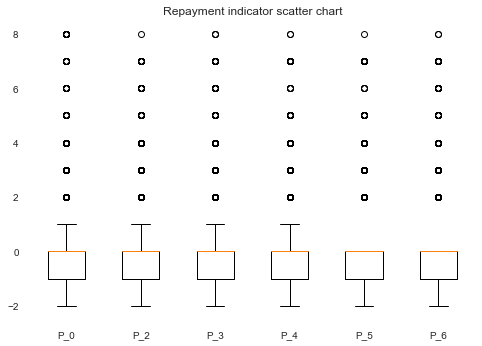

In [361]:
pay_indicators = [data['PAY_0'], data['PAY_2'], data['PAY_3'], data['PAY_4'], data['PAY_5'], data['PAY_6']]
plt.boxplot(pay_indicators, labels = ['P_0', 'P_2', 'P_3', 'P_4', 'P_5', 'P_6'])
plt.title('Repayment indicator scatter chart')
plt.show()

In [362]:
# Do one hot encoding for categorical columns and the add them to dataframe
data = pd.concat([data,pd.get_dummies(data['SEX'], prefix='SEX'), 
                       pd.get_dummies(data['EDUCATION'], prefix='EDUCATION'),
                       pd.get_dummies(data['MARRIAGE'], prefix='MARRIAGE')
                 ],axis=1)

# now drop the original SEX, EDUCATION, MARRIAGE columns 
data.drop(['SEX','EDUCATION','MARRIAGE'],axis=1, inplace=True)

# change all paid months with value -2 or -1 to zero
data.loc[(data.PAY_0 == -2), 'PAY_0'] = 0
data.loc[(data.PAY_0 == -1), 'PAY_0'] = 0
data.loc[(data.PAY_2 == -2), 'PAY_2'] = 0
data.loc[(data.PAY_2 == -1), 'PAY_2'] = 0
data.loc[(data.PAY_3 == -2), 'PAY_3'] = 0
data.loc[(data.PAY_3 == -1), 'PAY_3'] = 0
data.loc[(data.PAY_4 == -2), 'PAY_4'] = 0
data.loc[(data.PAY_4 == -1), 'PAY_4'] = 0
data.loc[(data.PAY_5 == -2), 'PAY_5'] = 0
data.loc[(data.PAY_5 == -1), 'PAY_5'] = 0
data.loc[(data.PAY_6 == -2), 'PAY_6'] = 0
data.loc[(data.PAY_6 == -1), 'PAY_6'] = 0

#make a copy of the data which we will use for credit limit prediction
credit = data.copy()

#data.to_csv("c:\\temp\\x.csv")

#SEX, EDUCATION, SEX, BILL_AMT columns dont have strong correlation with Default, so dropping them
data.drop(['AGE', 'SEX_0', 'SEX_1', 'EDUCATION_0', 'EDUCATION_1', 'EDUCATION_2', 'MARRIAGE_1', 'MARRIAGE_2', 
'MARRIAGE_3', 'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6'],axis=1, inplace=True)

print(data.columns)

Index(['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'DEFAULT'],
      dtype='object')


In [363]:
scaler = StandardScaler()

#scale selected columns
data[['LIMIT_BAL', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']] = scaler.fit_transform(data[['LIMIT_BAL', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']])

data.head()

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,-1.133563,2,2,0,0,0,0,-0.340591,-0.225117,-0.295459,-0.306874,-0.314159,-0.293220,1
1,-0.364148,0,2,0,0,0,2,-0.340591,-0.211661,-0.238403,-0.243306,-0.314159,-0.180118,1
2,-0.594973,0,0,0,0,0,0,-0.249090,-0.190028,-0.238403,-0.243306,-0.248573,-0.010466,0
3,-0.902738,0,0,0,0,0,0,-0.220036,-0.167573,-0.226992,-0.236949,-0.244048,-0.236669,0
4,-0.902738,0,0,0,0,0,0,-0.220036,1.332132,0.275099,0.265236,-0.268970,-0.254822,0


In [364]:
#predict defaulters
algosClass = []
algosClass.append(('Decision Tree',DecisionTreeClassifier()))
algosClass.append(('Random Forest Clsf',RandomForestClassifier(n_estimators=10)))
algosClass.append(('XGB',XGBClassifier()))
algosClass.append(('Support Vector Clsf',SVC(kernel="rbf")))
algosClass.append(('Logistic Regression',LogisticRegression()))

# remove the DEFAULT column from predictor variables
X = data.loc[:, data.columns.isin(['DEFAULT']) == False]
y = data['DEFAULT']


In [365]:
#Try various classifications models

df_eval = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC'])
for name, model in algosClass:
    accuracy     = np.mean(cross_val_score(model, X, y, cv=5, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X, y, cv=5, scoring='precision'))
    recall       = np.mean(cross_val_score(model, X, y, cv=5, scoring='recall'))
    f1           = np.mean(cross_val_score(model, X, y, cv=5, scoring='f1'))
    roc          = np.mean(cross_val_score(model, X, y, cv=5, scoring='roc_auc'))
    df_eval = pd.concat([df_eval, pd.DataFrame({'Model':name, 'Accuracy':accuracy, 'Precision':precision, 'Recall':recall, 'F1':f1, 'ROC':roc}, index=[0])], ignore_index=True)

print(df_eval)


                 Model  Accuracy  Precision    Recall        F1       ROC
0        Decision Tree  0.719621   0.383401  0.389509  0.388639  0.614734
1   Random Forest Clsf  0.801717   0.601685  0.338738  0.433577  0.720011
2                  XGB  0.811216   0.638676  0.363595  0.462904  0.755762
3  Support Vector Clsf  0.818611   0.677003  0.364052  0.473050  0.694335
4  Logistic Regression  0.817390   0.688034  0.338588  0.453373  0.758914


In [366]:
#X = preprocessing.scale(X) 
# transform the dataset
#oversample = SMOTE()
#X, y = oversample.fit_resample(X, y)

#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)


In [367]:

# Create logistic regression
logistic = linear_model.LogisticRegression(solver='lbfgs')

# Create regularization penalty space
penalty = [ 'l1','l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)

# Fit grid search
best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])


C:\ProgramData\Anaconda3\envs\datascience1\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\ProgramData\Anaconda3\envs\datascience1\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\ProgramData\Anaconda3\envs\datascience1\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Det

Best Penalty: l2
Best C: 1.0


In [368]:
# Use score method to get accuracy of model
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)   
rocauc = roc_auc_score(y_test, y_pred)

print(accuracy, precision, recall, f1, rocauc)

0.8130936227951153 0.689873417721519 0.32488822652757077 0.44174265450861194 0.6409245700051117


In [369]:
#Tuning Support Vector Classifier
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
#grid = GridSearchCV(SVC(probability=True), param_grid, refit = True, verbose = 1) 

#  gridSearchCV calculated following parameters:
clf = SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
   max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
   verbose=False)

best_model = clf.fit(X_train, y_train) 

#print the best hyperparameters
#print(best_model.best_estimator_)

y_pred = best_model.predict(X_test)

print(confusion_matrix(y_test,y_pred))

#print model accuracy
print(classification_report(y_test, y_pred))
score = best_model.score(X_test, y_test)
print(score)
rocauc = roc_auc_score(y_test, y_pred)
print("ROCAUC:", rocauc)

[[6506  325]
 [1315  698]]
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      6831
           1       0.68      0.35      0.46      2013

    accuracy                           0.81      8844
   macro avg       0.76      0.65      0.67      8844
weighted avg       0.80      0.81      0.79      8844

0.8145635459068294
ROCAUC: 0.6495844642672868


In [370]:

# Create XGBoost Classifier
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
# grid_search = GridSearchCV(
#     estimator=estimator,
#     param_grid=parameters,
#     scoring = 'roc_auc',
#     n_jobs = 10,
#     cv = 10,
#     verbose=True
# )
# best_model = grid_search.fit(X_train, y_train)

#XGB which we got from grid_search
clf = XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1,  monotone_constraints=None,
              n_estimators=100, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=42, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

best_model = clf.fit(X_train, y_train) 

#print the best hyperparameters
#print(best_model.best_estimator_)

y_pred = best_model.predict(X_test)

print(confusion_matrix(y_test,y_pred))

#print model accuracy
print(classification_report(y_test, y_pred))
score = best_model.score(X_test, y_test)
print(score)

rocauc = roc_auc_score(y_test, y_pred)
print("ROCAUC:", rocauc)

[[6480  351]
 [1316  697]]
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      6831
           1       0.67      0.35      0.46      2013

    accuracy                           0.81      8844
   macro avg       0.75      0.65      0.67      8844
weighted avg       0.79      0.81      0.79      8844

0.8115106286748078
ROCAUC: 0.6474329899133892


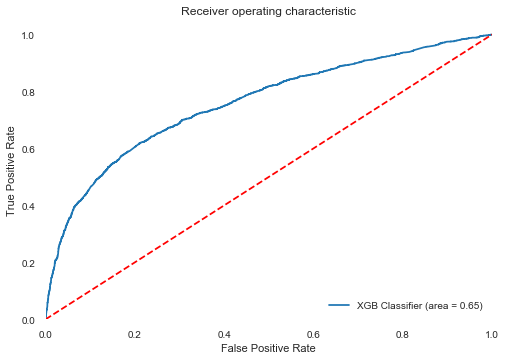

In [371]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, best_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGB Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

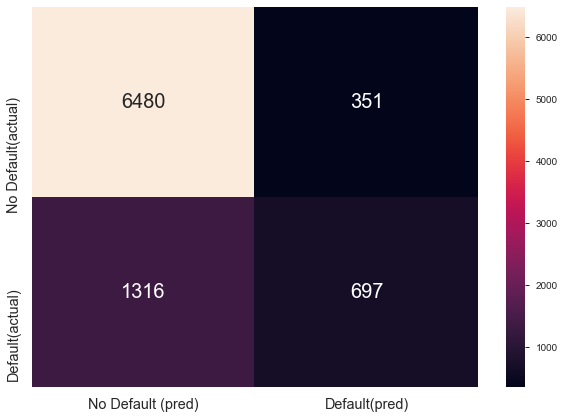

In [372]:
m = confusion_matrix(y_test, y_pred, labels= [0, 1])

df_cm = pd.DataFrame(m, index =  ['No Default(actual)', 'Default(actual)'],
                  columns =  ['No Default (pred)', 'Default(pred)'])
plt.figure(figsize = (10,7))
plt.xticks(fontsize='x-large'  )
plt.yticks(fontsize='x-large'  )
sn.heatmap(df_cm, annot=True, fmt='g', annot_kws={"size": 20})